In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import kagglehub
path = kagglehub.dataset_download("hijest/englishrussian-dictionary-for-machine-translate")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'englishrussian-dictionary-for-machine-translate' dataset.
Path to dataset files: /kaggle/input/englishrussian-dictionary-for-machine-translate


In [4]:
import string
import re
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import pandas as pd

# Путь к вашему файлу
text = "/kaggle/input/englishrussian-dictionary-for-machine-translate/rus.txt"

# Чтение файла и обработка строк
with open(text, encoding='utf-8') as file:
    lines = file.read().split("\n")

pairs = []

for line in lines:
    parts = line.split("\t")
    if len(parts) >= 2:
        english, russian = parts[0], parts[1]
        # Цель — английский русский
        english = "[start] " + english + " [end]"
        pairs.append((russian, english))

In [5]:
df = pd.DataFrame(pairs)
df.head(20)

,0,1
0,Марш!,[start] Go. [end]
1,Иди.,[start] Go. [end]
2,Идите.,[start] Go. [end]
3,Здравствуйте.,[start] Hi. [end]
4,Привет!,[start] Hi. [end]
5,Хай.,[start] Hi. [end]
6,Здрасте.,[start] Hi. [end]
7,Здоро́во!,[start] Hi. [end]
8,Беги!,[start] Run! [end]
9,Бегите!,[start] Run! [end]


In [7]:
import random
print(random.choice(pairs))
print(len(pairs))

('Все трое засмеялись.', '[start] The three of them began to laugh. [end]')
363386


In [8]:
random.shuffle(pairs)
num_val_samples = int(0.2 * len(pairs))
num_train_samples = len(pairs) - 2 * num_val_samples
train_pairs = pairs[:num_train_samples]
val_pairs = pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = pairs[num_train_samples + num_val_samples:]

In [9]:
print(len(train_pairs))
print(len(val_pairs))
print(len(test_pairs))

218032
72677
72677


In [10]:
strip_chars = string.punctuation + "." + "," + "?" + "!"

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

In [11]:
custom_standardization(pairs)

<tf.Tensor: shape=(363386, 2), dtype=string, numpy=
array([[b'\xd0\x90\xd1\x82\xd0\xbc\xd0\xbe\xd1\x81\xd1\x84\xd0\xb5\xd1\x80\xd0\xbd\xd1\x8b\xd0\xb9 \xd0\xba\xd0\xb8\xd1\x81\xd0\xbb\xd0\xbe\xd1\x80\xd0\xbe\xd0\xb4 \xd1\x80\xd0\xb0\xd1\x81\xd1\x82\xd0\xb2\xd0\xbe\xd1\x80\xd1\x8f\xd0\xb5\xd1\x82\xd1\x81\xd1\x8f \xd0\xb2 \xd0\xb2\xd0\xbe\xd0\xb4\xd0\xb5',
        b'start oxygen from the air dissolves in water end'],
       [b'\xd0\x9c\xd0\xbd\xd0\xb5 \xd0\xbd\xd0\xb5 \xd1\x83\xd0\xb4\xd0\xb0\xd0\xbb\xd0\xbe\xd1\x81\xd1\x8c \xd0\xbd\xd0\xb0\xd0\xb9\xd1\x82\xd0\xb8 \xd0\xb5\xd0\xb3\xd0\xbe \xd0\xb4\xd0\xbe\xd0\xbc',
        b'start i couldnt find his house end'],
       [b'\xd0\xa2\xd0\xbe\xd0\xbc \xd0\xb2\xd1\x80\xd0\xbe\xd0\xb4\xd0\xb5 \xd0\xbd\xd0\xb5\xd0\xbf\xd0\xbb\xd0\xbe\xd1\x85\xd0\xbe\xd0\xb9 \xd1\x87\xd0\xb5\xd0\xbb\xd0\xbe\xd0\xb2\xd0\xb5\xd0\xba',
        b'start tom seems to be a kind person end'],
       ...,
       [b'\xd0\x9c\xd1\x8d\xd1\x80\xd0\xb8 \xd0\xbd\xd0\xb5 \xd0\x

In [12]:
from keras import layers
vocab_size = 30000
sequence_length = 30 #было 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_russian_texts = [pair[0] for pair in train_pairs]
train_english_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_russian_texts)
target_vectorization.adapt(train_english_texts)

In [13]:
batch_size = 64

def format_dataset(rus, eng):
    rus = source_vectorization(rus)
    eng = target_vectorization(eng)
    return ({
        "russian": rus,
        "english": eng[:, :-1],
    }, eng[:, 1:])

In [14]:
def make_dataset(pairs):
    rus_texts, eng_texts = zip(*pairs)
    rus_texts = list(rus_texts)
    eng_texts = list(eng_texts)
    dataset = tf.data.Dataset.from_tensor_slices((rus_texts, eng_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [15]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['russian'].shape: {inputs['russian'].shape}")
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['russian'].shape: (64, 30)
inputs['english'].shape: (64, 30)
targets.shape: (64, 30)


In [16]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [17]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [18]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [19]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="russian")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

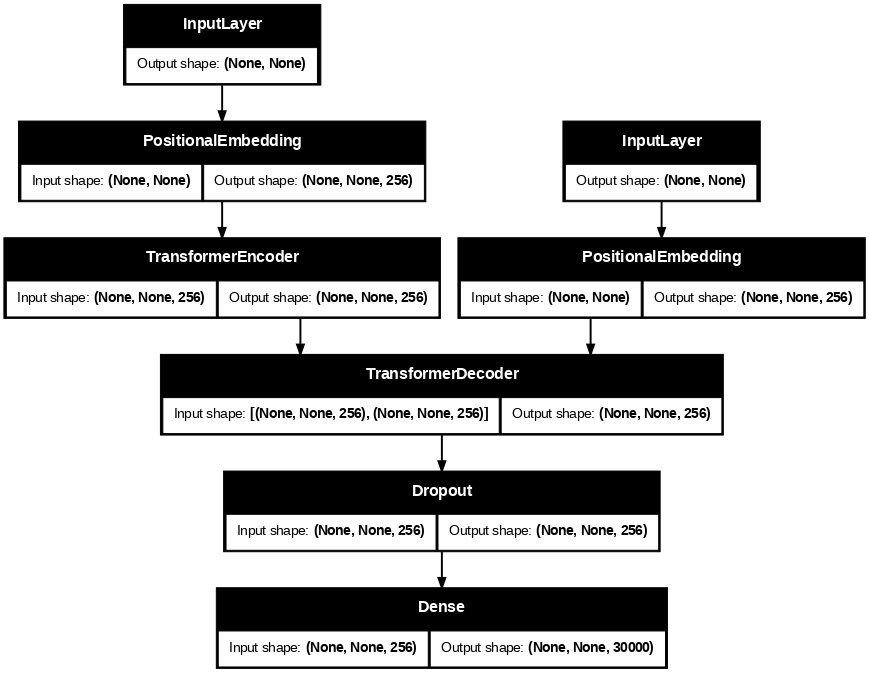

In [20]:
plot_model(model, show_shapes=True, dpi=70)